In [1]:
import os
import glob
import pickle
import shap

import pandas as pd
import numpy as np
import category_encoders as ce


from numpy import argmax
from PIL import Image, ImageDraw, ImageFilter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#tensorflow2系の場合、以下はエラー・・・
#from tensorflow.Keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'meiryo'}
plt.rc('font', **font)

In [2]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

def mask_circle_solid(arr_img, background_color = (0,0,0), blur_radius = -5):
    pil_img = Image.fromarray(np.uint8(arr_img))
    background = Image.new(pil_img.mode, pil_img.size, background_color)
    mask = Image.new("L", pil_img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((blur_radius, blur_radius, pil_img.size[0] - blur_radius, pil_img.size[1] - blur_radius), fill=255)
    
    return np.array(Image.composite(pil_img, background, mask))

In [16]:
class MyImageDataGenerator(ImageDataGenerator):
    def __init__(self, featurewise_center = False, samplewise_center = False, 
                 featurewise_std_normalization = False, samplewise_std_normalization = False, 
                 zca_whitening = False, zca_epsilon = 1e-06, rotation_range = 0.0, width_shift_range = 0.0, 
                 height_shift_range = 0.0, brightness_range = None, shear_range = 0.0, zoom_range = 0.0, 
                 channel_shift_range = 0.0, fill_mode = 'nearest', cval = 0.0, horizontal_flip = False, 
                 vertical_flip = False, rescale = None, preprocessing_function = None, data_format = None, validation_split = 0.0, 
                 mask_circle = False):
        # 親クラスのコンストラクタ
        super().__init__(featurewise_center, samplewise_center, featurewise_std_normalization, samplewise_std_normalization, zca_whitening, zca_epsilon, rotation_range, width_shift_range, height_shift_range, brightness_range, shear_range, zoom_range, channel_shift_range, fill_mode, cval, horizontal_flip, vertical_flip, rescale, preprocessing_function, data_format, validation_split)
        # 拡張処理のパラメーター
        assert isinstance(mask_circle,bool)
        self.mask_circle = mask_circle

    def flow(self, x, y=None, batch_size=32, shuffle=True, sample_weight=None,
             seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None):
        batches = super().flow(x=x, y=y, batch_size=batch_size, shuffle=shuffle, sample_weight=sample_weight,
                               seed=seed, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format, subset=subset)

        while True:
            batch_x, batch_y = next(batches)
            if self.mask_circle:
                x = np.zeros(batch_x.shape)
                for i in range(batch_x.shape[0]):
                    x[i] = mask_circle_solid(batch_x[i] * 255) / 255
                batch_x = x
            yield batch_x, batch_y

In [19]:
datagen = MyImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.02,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True,
        mask_circle=True,
)

In [6]:
image_size=128
X = []
Y = []

for variety_id in tqdm([dir_name[-2:] for dir_name in glob.glob("./images/*")]):
    for img_file_path in glob.glob("./images/" + variety_id + "/*"):
        image = Image.open(img_file_path)
        image = image.convert("RGB")
        
        #縦横比を保ったまま正方形にする
        #image = expand2square(image, (0, 0, 0)).resize((image_size, image_size), Image.LANCZOS)
        
        image = image.resize((image_size, image_size))
        X.append(np.array(image))
        Y.append(variety_id)
del image

100%|██████████| 46/46 [00:05<00:00,  8.11it/s]


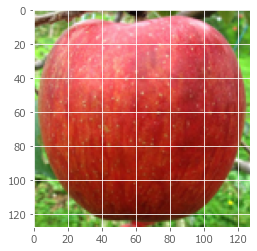

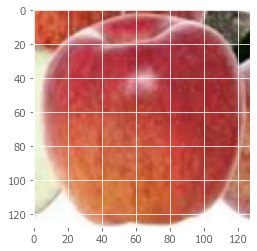

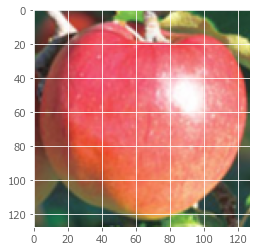

In [7]:
for i in range(3):
    plt.imshow(X[i])
    plt.show()

In [8]:
Y_variety = [int(i) - 1 for i in Y]
output_num = len(set(Y_variety))

In [9]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = 3, activation="relu", input_shape=(image_size,image_size,3)))
    model.add(Conv2D(16, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    model.add(Conv2D(32, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    model.add(Conv2D(64, kernel_size = 3, activation="relu"))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(output_num, activation='softmax'))
    return model

In [10]:
def create_model_vgg():
    #base_model=VGG16(weights='imagenet',include_top=False,
    #             input_tensor=Input(shape=(image_size,image_size,3)))
    base_model=VGG16(weights='imagenet',include_top=False,
                 input_shape=(image_size,image_size,3))
    x = base_model.output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.3)(x)
    prediction = Dense(output_num, activation='softmax')(x)

    for layer in base_model.layers[:15]:
        layer.trainable=False
    
    return Model(inputs=base_model.input,outputs=prediction)

In [14]:
def model_train(X, Y, train_model=True):
    
    acc_mean = 0
    
    X = np.array(X).astype("float32") / 255
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
        
        print('#'*25)
        print('### FOLD %i'%(fold+1))
        print('#'*25)
        
        ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
        Y = np.array(ce_ohe.fit_transform(Y))
        
        X_train = X[train_index]
        X_valid = X[test_index]
        Y_train = Y[train_index]
        Y_valid = Y[test_index]

        #テストデータにもマスキング
        for i in range(len(X_valid)):
            X_valid[i] = mask_circle_solid(X_valid[i] * 255) / 255

        if train_model:
        
            datagen.fit(X_train)

            model = create_model_vgg()
            model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
            model.summary()

            reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience=4, 
                                                    verbose=1, 
                                                    factor=0.6, 
                                                    min_lr=0.00001)

            modelCheckpoint = ModelCheckpoint(filepath = "model/model_" + str(fold) + ".h5",
                                                  monitor='val_accuracy',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  period=1)

            earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
        
        
            
            hist = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=64),
                                     epochs = 10, validation_data = (X_valid,Y_valid),
                                     verbose = 2, steps_per_epoch=X_train.shape[0] // 64
                                     , callbacks=[reduceLROnPlateau,modelCheckpoint,earlyStopping])

            fig = plt.figure(figsize=(12, 16))
            fig.subplots_adjust(wspace=0.5)
            fig.suptitle("hist", fontsize=20)

            ax1 = fig.add_subplot(211,
                                  title="Loss:",
                                  ylabel="Loss",
                                  xlabel="Epoch")
            ax1.plot(hist.history["loss"])
            ax1.legend(["Train", "Test"], loc="upper left")

            ax2 = fig.add_subplot(212,
                                  title="val Acc:",
                                  ylabel="val Acc",
                                  xlabel="Epoch")
            ax2.plot(hist.history['val_accuracy'])
            ax2.legend(["Train", "Test"], loc="upper left")

            plt.show()
        
        model = load_model("model/model_" + str(fold) + ".h5", compile=False)
        
        pred = model.predict(X_valid)
        Y_pred_classes = argmax(pred, axis=1)
        Y_true = argmax(Y_valid, axis=1)
        ACC_pred = accuracy_score(Y_pred_classes, Y_true)
        
        Y_pred_classes = np.argmax(pred,axis = 1) 
        
        errors = (Y_pred_classes - Y_true != 0)
        Y_pred_classes_errors = Y_pred_classes[errors]
        Y_pred_errors = pred[errors]
        Y_true_errors = Y_true[errors]
        X_val_errors = X_valid[errors]

        def display_errors(errors_index, img_errors, pred_errors, obs_errors):
            n = 0
            nrows = 2
            ncols = 5
            fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
            for row in range(nrows):
                for col in range(ncols):
                    error = errors_index[n]
                    ax[row, col].imshow((img_errors[error]).reshape((image_size, image_size,3)))
                    ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
                    n += 1
            plt.show()

        Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
        true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
        delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
        sorted_dela_errors = np.argsort(delta_pred_true_errors)
        most_important_errors = sorted_dela_errors[-10:]

        display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)
        
        #explainer = shap.DeepExplainer(model, (X_train[0:100]))
        #for i in most_important_errors:
        #    shap_values = explainer.shap_values(X_val_errors[[i]])
        #    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(Y_pred_errors[i][x]) for x in range(output_num)]).reshape(1,output_num)
        #    print("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[i],Y_true_errors[i]))
        #    
        #    shap.image_plot(shap_values, X_val_errors[[i]] ,index_names)
        #    plt.gcf().set_size_inches(20, 20)

        acc_mean += ACC_pred/5
        print('>>>> FOLD %i val Acc ='%(fold+1), ACC_pred)
        print()
    
    print('>>>> Acc mean =', acc_mean)
    acc_mean


#########################
### FOLD 1
#########################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

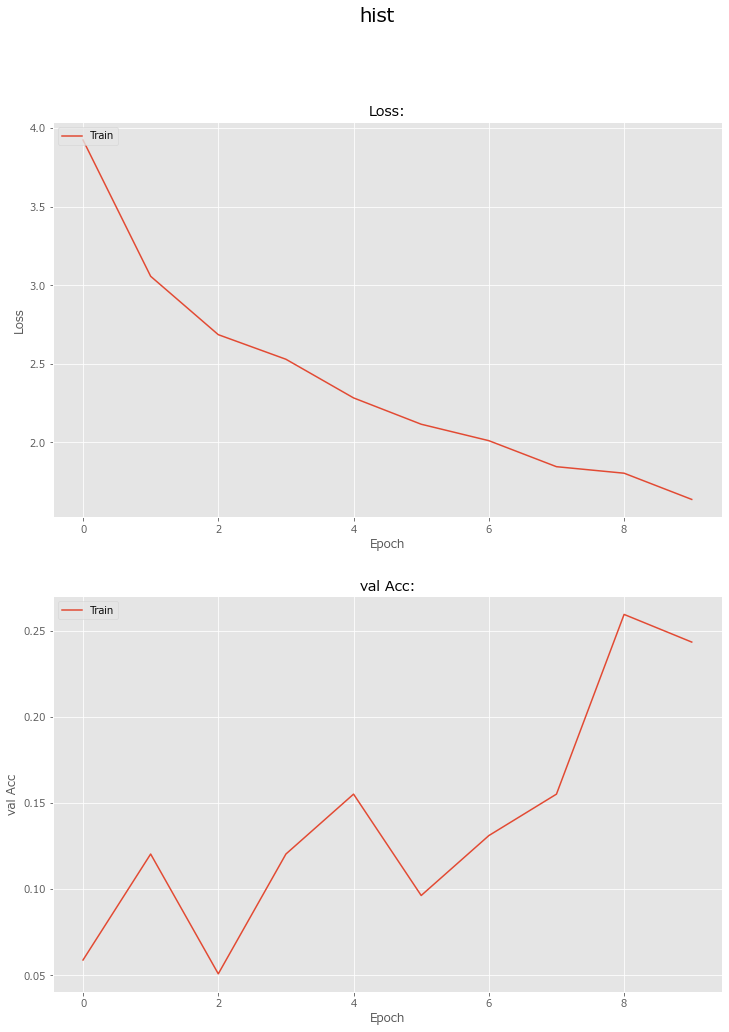

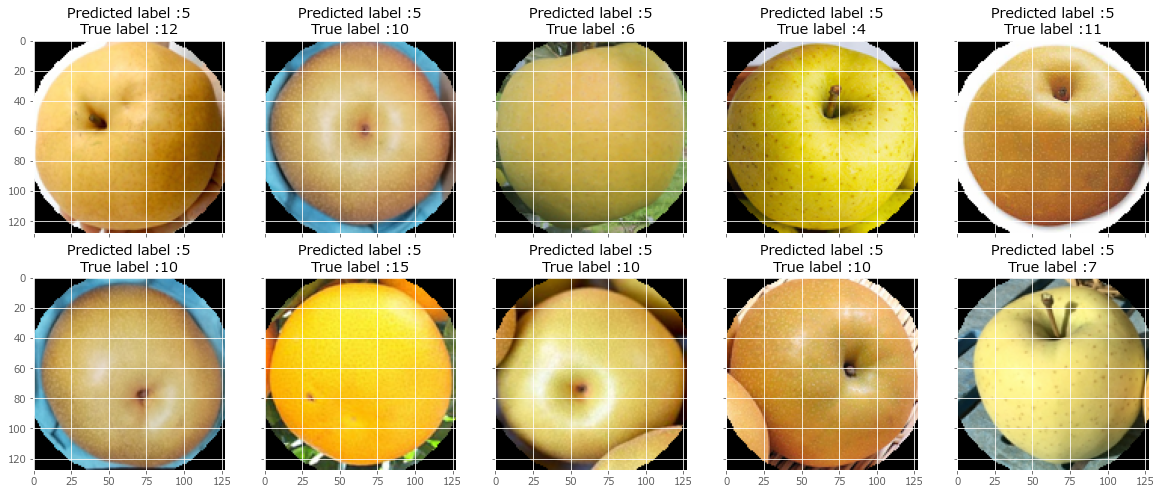

>>>> FOLD 1 val Acc = 0.25935828877005346

#########################
### FOLD 2
#########################
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
___________________

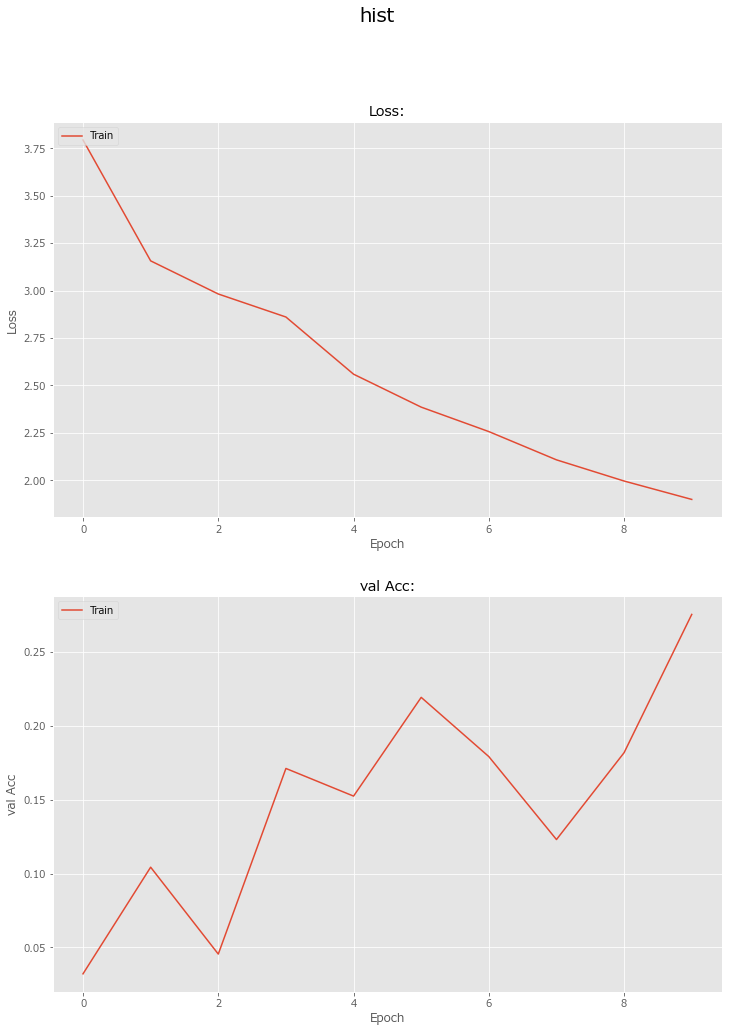

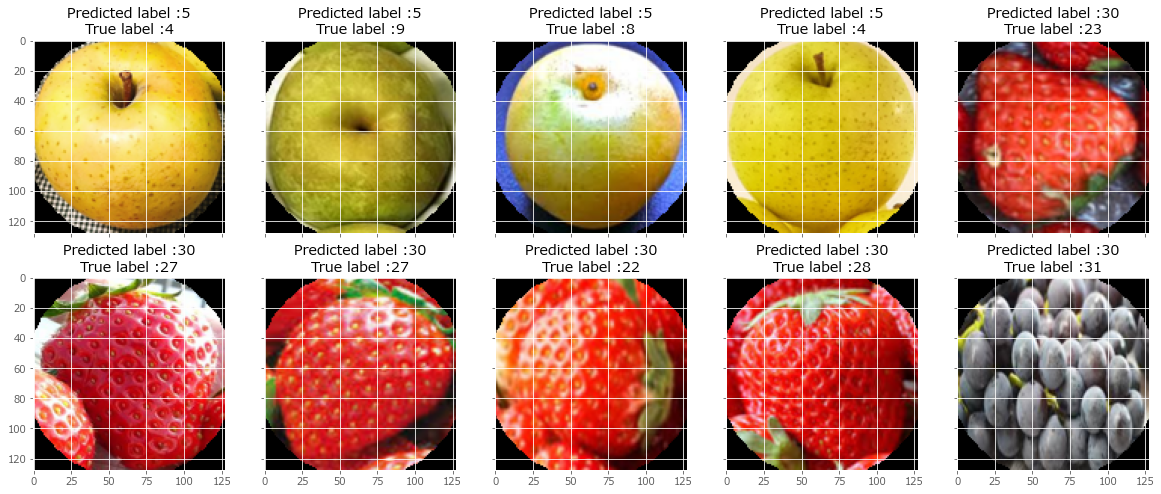

>>>> FOLD 2 val Acc = 0.27540106951871657

#########################
### FOLD 3
#########################
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
___________________

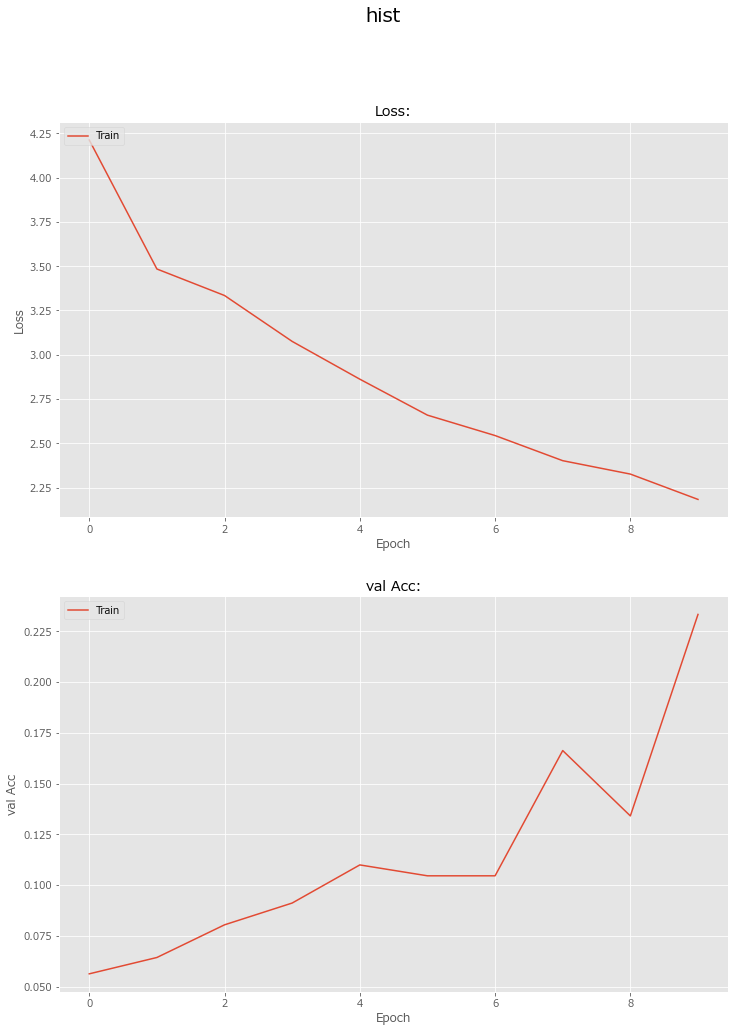

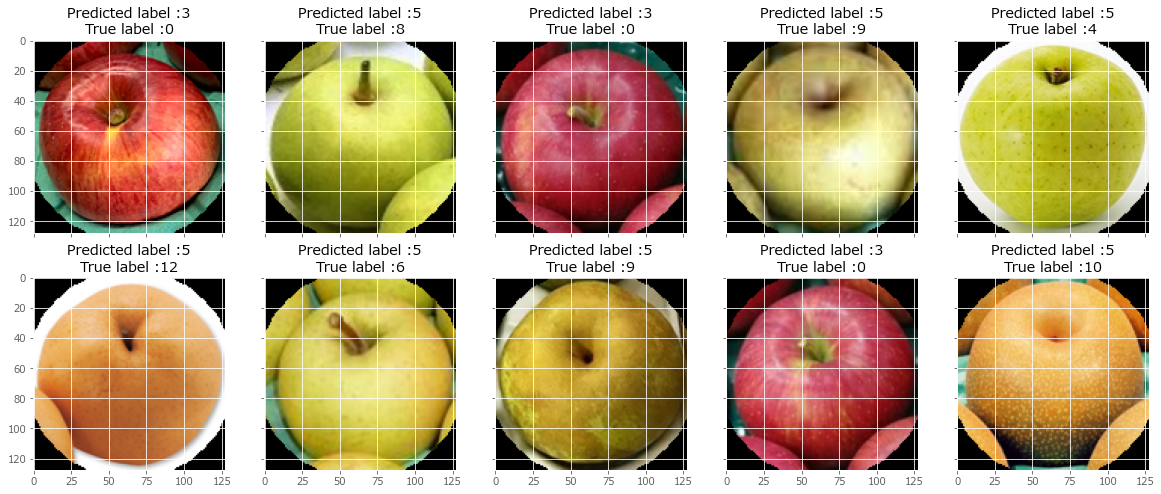

>>>> FOLD 3 val Acc = 0.23324396782841822

#########################
### FOLD 4
#########################
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
___________________

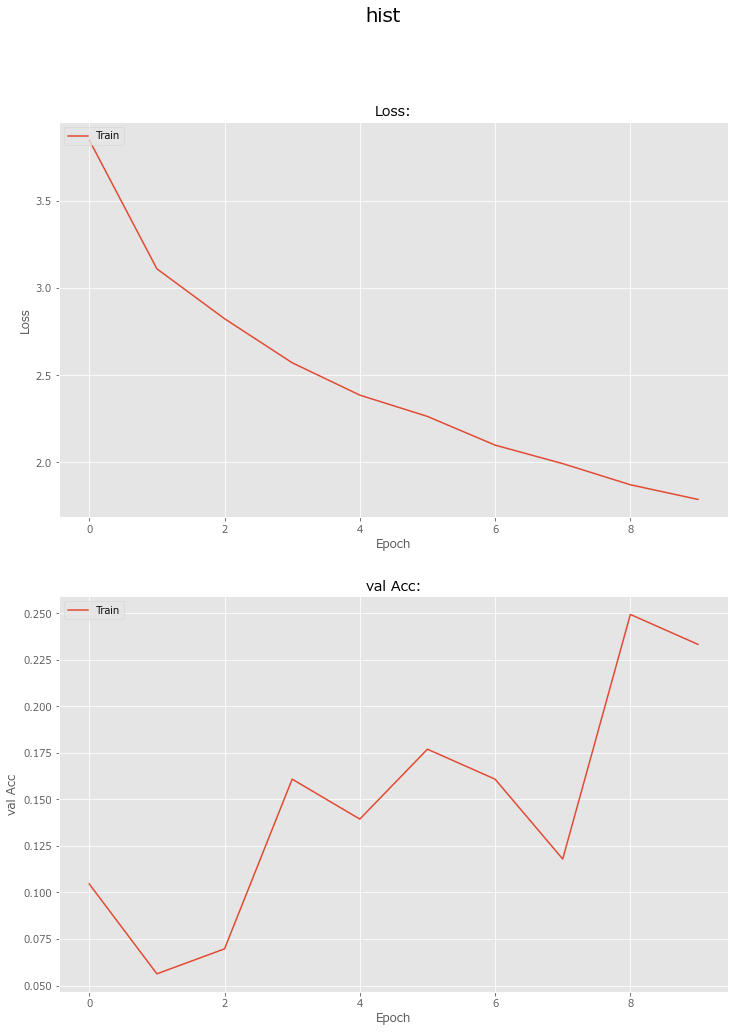

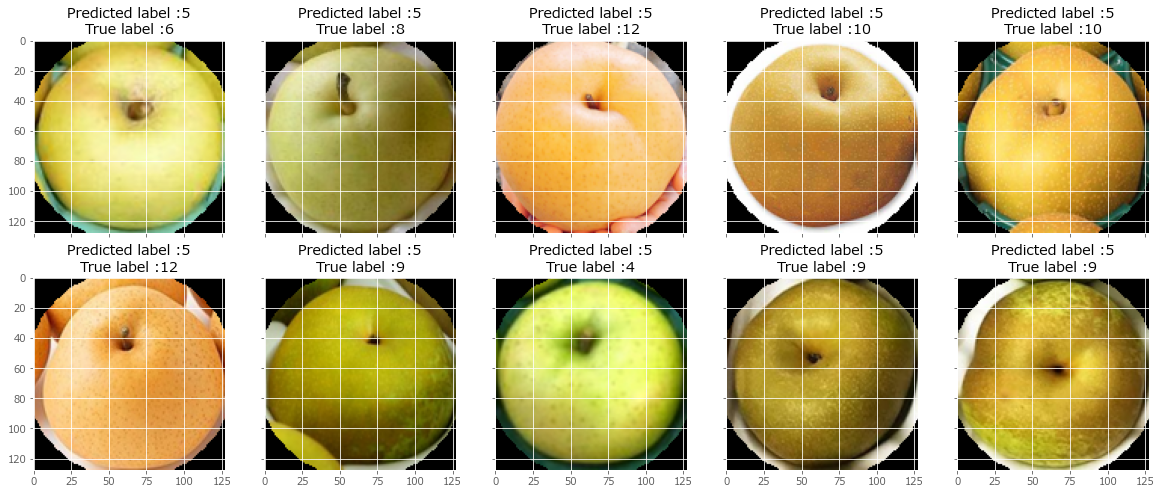

>>>> FOLD 4 val Acc = 0.24932975871313673

#########################
### FOLD 5
#########################
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
___________________

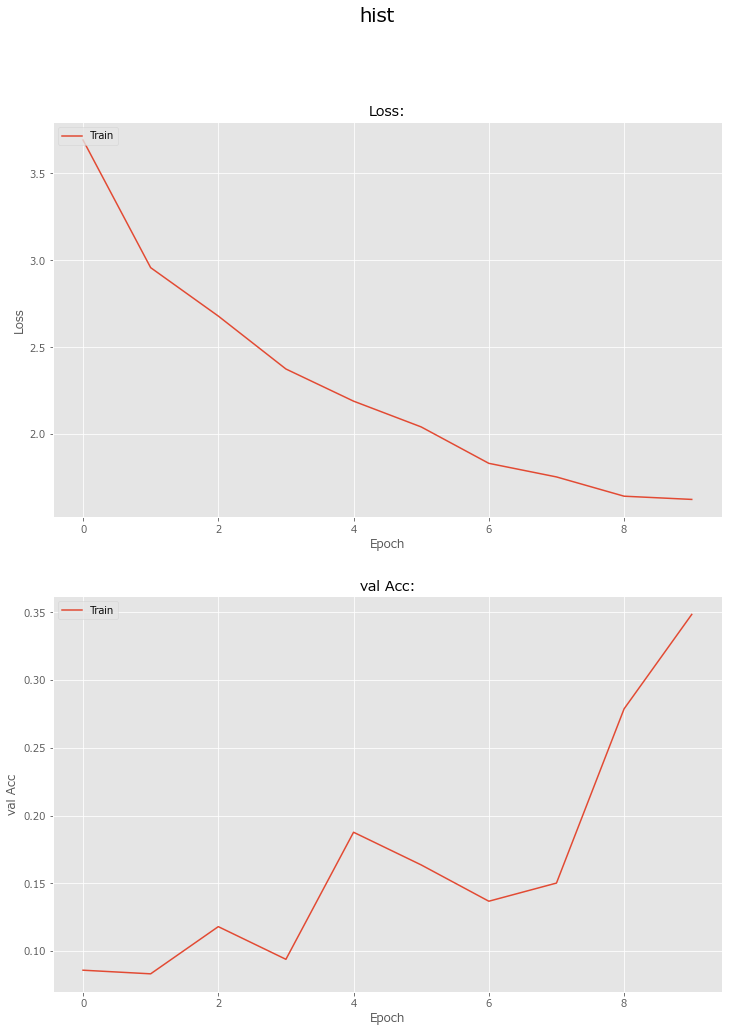

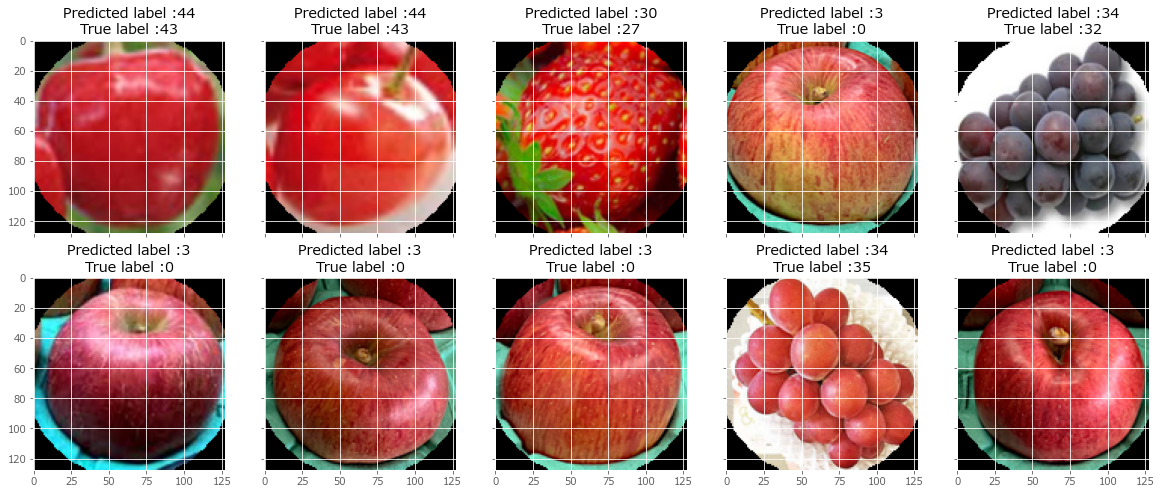

>>>> FOLD 5 val Acc = 0.3485254691689008

>>>> Acc mean = 0.27317171079984515


In [18]:
model_train(X,Y,train_model=True)

In [ ]:
file_list = []
test_path = "./fruits-360/Test/"
Y_test = []

for dir_name in os.listdir(test_path):
    if "Apple" in dir_name:
        for file_name in os.listdir(test_path + dir_name):
            Y_test.append(dir_name)
            file_list.append(test_path + dir_name + "/" + file_name)

In [ ]:
image_size=80
X_test = []

for image_path in file_list:
    #画像ファイル取得
    img_file = glob.glob(image_path)
    if not img_file:
        print(image_path)
        continue
    image = Image.open(img_file[0])
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    X_test.append(np.array(image))
    
del image

In [ ]:
X_test = np.array(X_test).astype("float32") / 255
ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
Y_test = np.array(ce_ohe.fit_transform(Y_test))

In [ ]:
pred = np.zeros((len(X_test),13))

for i in range(5):
    print(i)
    model = pickle.load(open("model/model_"+ str(i) +".sav","rb"))
    temp = model.predict(X_test)
    pred += temp

In [ ]:
Y_pred = argmax(pred, axis=1)
Y_true = argmax(Y_test, axis=1)
ACC_pred = accuracy_score(Y_pred, Y_true)
print('>>>> val Acc =', ACC_pred)

In [ ]:
X_test.shape

In [ ]:
#Y_pred_classes = np.argmax(pred,axis = 1) 
#Y_true = np.argmax(Y_val,axis = 1)

In [ ]:
errors = (Y_pred - Y_true != 0)

Y_pred_classes_errors = Y_pred[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

In [ ]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((image_size,image_size,3)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()
    
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
np.array(X).shape

In [ ]:
#When describing Deep Learning, we use DeepExplainer.
explainer = shap.DeepExplainer(model, (np.array(X)[0:100]))

#Check out the 10 data that the model has mistakenly predicted.
for i in most_important_errors:
    
    #Calculates the SHAP value.
    shap_values = explainer.shap_values(X_val_errors[[i]])
    
    #The following two lines are extras. It works even if you turn it off.
    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(Y_pred_errors[i][x]) for x in range(10)]).reshape(1,10)
    print("Predicted label :{}\nTrue label :{}".format(Y_pred_classes_errors[i],Y_true_errors[i]))
    
    #Displays the results.
    shap.image_plot(shap_values, X_val_errors[[i]] ,index_names ,show=False)
    plt.show()